In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange

### Job-shop scheduling

We use `i` for job indices and `j` for operations indices, so `(i, j)` refers to operation $O_{ij}$. This is different from what other authors do, e.g. use `i` for machines and `j` for job indices. We call the order in which a job visits machines the "machine visit order", denoted `order` in code. For each machine, we call the order of jobs that visit this machine the "machine order", denoted `machine_order` in code.

In [2]:
instance = {
    # machine visit order of each job
    'order': [
        [2, 1, 3],
        [1, 2, 3, 4],
        [1, 2],
    ],
    # processing times
    'processing': [
        [3, 4, 2],
        [4, 3, 5, 2],
        [8, 3],
    ],
    #'release': ..., # not implemented
}

We generate random job-shop instances, roughly following the method of (Taillard, 1993).

In [3]:
def generate_instance(machines=10, jobs=10):
    """Generate a random job-shop instances."""
    rng = np.random.default_rng()

    # sample uniformly distributed processing times
    processing = [ [ rng.uniform(1, 100) for _ in range(machines) ] for _ in range(jobs) ]

    # initial machine order
    order = [ list(range(machines)) for _ in range(jobs) ]
    # randomly permute the order
    for i in range(jobs):
        for j in range(machines):
            # swap M_{i,j} and M_{i, U[j,machines]} (see Taillard)
            u = rng.integers(j, machines)
            temp = order[i][j]
            order[i][j] = order[i][u]
            order[i][u] = temp
    
    return { 'order': order, 'processing': processing }        

In [4]:
def indices(instance):
    """All operation (i,j) indices as consecutive numbers."""
    p = instance['processing']
    J = range(len(p)) # job indices (i)
    N = [range(len(p[i])) for i in J] # operation indices (j)
    return [(i, j) for i in J for j in N[i]] # combined (i, j)

def machine_indices(instance):
    # use sum to flatten list of lists (recall that `['a'] + ['b'] = ['a', 'b']`)
    return sorted(set(sum(instance['order'], [])))

The following two functions do not assume that `indices` contains consecutive numbers 1,...,n like `indices()` produces, but allows them to be 'ragged'. This is helpful when dealing with dynamic problems, where part of the original problem may be reconsidered.

In [5]:
def job_indices(indices):
    """Get all job indices i from list of (i,j) indices."""
    return sorted(set([i[0] for i in indices]))

def operation_indices(indices):
    """Map job index i to list of operation indices 1,...,n_i."""
    return { job: sorted([j for (i, j) in indices if i == job]) for job in job_indices(indices) }

### Solve exact

We solve for the minimum makespan objective.

In [6]:
import gurobipy as gp
from itertools import combinations

def solve(instance, gap=0.0, timelimit=0, consolelog=False, logfile=None):
    env = gp.Env(empty=True)
    if not consolelog:
        env.setParam('LogToConsole', 0)  # disable console logging
    if logfile is not None:
        env.setParam('LogFile', logfile)
        # make sure directory exists
        os.makedirs(os.path.dirname(os.path.abspath(logfile)), exist_ok=True)
    if timelimit > 0:
        env.setParam('TimeLimit', timelimit)

    env.start()
    g = gp.Model(env=env)

    # big-M
    M = 1000

    ij = indices(instance)
    mx = machine_indices(instance)
    ix = job_indices(ij)
    jx = operation_indices(ij)

    p = instance['processing']
    
    # non-negative starting times
    y = { (i, j): g.addVar(obj=0, vtype=gp.GRB.CONTINUOUS, name=f"y_{i}_{j}") for i, j in ij }
    
    # conjunctions
    for i in ix:
        for j, l in zip(jx[i][:-1], jx[i][1:]):
            g.addConstr(y[i, j] + p[i][j] <= y[i, l])

    # disjunctions
    s = {}
    for m in mx:
        for i1, i2 in combinations(ix, 2):
            try:
                j1 = instance['order'][i1].index(m)
                j2 = instance['order'][i2].index(m)
            except ValueError:
                # machine not visited by one of the jobs
                continue
            
            # disjunctive variables for "selecting" disjunctive arcs
            # s[machine m, job i1, job i2] == true iff job i2 before job i1
            s[m, i1, i2] = g.addVar(obj=0, vtype=gp.GRB.BINARY, name=f"s_{m}_{i1}_{i2}")
            
            # i1 before i2
            g.addConstr(y[i1, j1] + p[i1][j1] <= y[i2, j2] + s[m, i1, i2] * M)

            # i2 before i1
            g.addConstr(y[i2, j2] + p[i2][j2] <= y[i1, j1] + (1 - s[m, i1, i2]) * M)

    # non-negative makespan
    makespan = g.addVar(obj=1, vtype=gp.GRB.CONTINUOUS, name="makespan")
    # makespan constraints
    for i, j in ij:
        g.addConstr(y[i, j] + p[i][j] <= makespan)
    
    g.ModelSense = gp.GRB.MINIMIZE
    g.Params.MIPGap = gap
    g.update()
    g.optimize()

    y = { k : (v.X if hasattr(v, 'X') else v) for k, v in y.items() }
    return y, g.getObjective().getValue()

In [7]:
schedule, obj = solve(generate_instance())

### Automaton

In [8]:
import networkx as nx
from networkx import topological_sort

class Automaton:
    """Dynamically updates disjunctive graph augmented with starting time lower
    bounds. Assumes non-negative starting times.

    Automaton.D is a networkx graph representing the disjunctive graph. Each
    node has the following attributes:

    - `LB` contains the starting time lower bound.
    - `done` (0 or 1) indicates whether the operation has been scheduled.
    - `action_mask` indicates whether this node encodes an operation that can be
      scheduled next, i.e, a valid action, thus encoding the action space mask."""

    def __init__(self, instance):
        self.order = instance['order']
        self.processing = instance['processing']
        
        self.indices = indices(instance)
        self.machine_indices = machine_indices(instance)
        self.job_indices = job_indices(self.indices)
        self.operation_indices = operation_indices(self.indices)

        # map machine m to list of scheduled indices (i, j)
        self.machine_order = { m: [] for m in self.machine_indices }
        # map from job index i to list of unscheduled operation indices j
        # use list(...) to create a copy, reversed(...) to use .pop()
        self.unscheduled = { i: list(reversed(self.operation_indices[i])) for i in self.job_indices }
        self.done = False
        
        # build the initial disjunctive graph
        self.D = nx.DiGraph()

        # add nodes
        for i, j in self.indices:
            # also set action_mask for every first operation (j == 0) of each
            self.D.add_node((i, j), label=((i, j)), LB=0, done=0, action_mask=int(j == 0))
        
        # conjunctions
        for i in self.job_indices:
            for j1, j2 in zip(self.operation_indices[i][:-1], self.operation_indices[i][1:]):
                self.D.add_edge((i, j1), (i, j2), weight=self.processing[i][j1], arc_type='c')

        # calculate initial lower bounds for empty schedule
        self.update_LB()


    def update_LB(self):
        for v in topological_sort(self.D):
            for u in self.D.predecessors(v):
                self.D.nodes[v]['LB'] = max(self.D.nodes[v]['LB'], self.D.nodes[u]['LB'] + self.D.edges[u, v]['weight'])

    
    def step(self, i):
        # get next operation index j
        j = self.unscheduled[i].pop()
        # mark operation (i, j) as done...
        self.D.nodes[i, j]['done'] = 1
        # ...and its action as invalid...
        self.D.nodes[i, j]['action_mask'] = 0
        if len(self.unscheduled[i]) > 0:
            # ...and the next operation (if any) for this job as next valid action
            self.D.nodes[i, self.unscheduled[i][-1]]['action_mask'] = 1
        else:
            # remove key from dict if job is completely done
            # (we depend on this in the optimal schedule backtracking procedure)
            del self.unscheduled[i]
        
        # operation (i, j) needs machine m
        m = self.order[i][j]

        # any operations scheduled on this machine?
        if len(self.machine_order[m]) > 0: 
            # ..then get the last one
            prev_i, prev_j = self.machine_order[m][-1]
            # ...and add disjunctive arc from it to current operation
            self.D.add_edge((prev_i, prev_j), (i, j), weight=self.processing[prev_i][prev_j], arc_type='d')

        # append current operation to machine order
        self.machine_order[m].append((i, j))

        # done when all operations all scheduled
        self.done = not self.unscheduled # empty dictionary is equivalent to False
        
        # update starting time lower bounds
        self.update_LB()


    def get_obj(self):
        """Compute the makespan objective."""
        makespan = 0
        for i, j in self.indices:
            makespan = max(makespan, self.D.nodes[i, j]['LB'] + self.processing[i][j])
        return makespan

### Draw disjunctive graph

In [9]:
from matplotlib import colormaps

def draw_disjunctive_graph(automaton, operation_indices=True, time_labels=True):
    """For each job, operations are shown as a row. Operations on the same machine have the same color."""
    pos = {}
    for i in automaton.job_indices:
        for j in automaton.operation_indices[i]:
            # grid positions
            pos[i, j] = (j, -i)

    node_color = []
    cmap = colormaps["Paired"] # machine colors
    for i, j in automaton.D.nodes:
        # operation color based on machine
        node_color.append(cmap(automaton.order[i][j]))

    nx.draw_networkx(automaton.D, pos=pos, node_color=node_color, with_labels=False, node_size=1600, arrowsize=20)

    # operation indices
    if operation_indices:
        labels = { (i, j): f"({i}, {j})" for i, j in automaton.D.nodes }
        nx.draw_networkx_labels(automaton.D, labels=labels, font_size=9, pos={ (i, j): (pos[i, j][0], pos[i, j][1] + 0.06) for i, j in pos })
    
    # LB labels with processing time in parentheses
    if time_labels:
        labels = { (i, j): f"{automaton.D.nodes[i, j]['LB']:.2f} ({automaton.processing[i][j]:.2f})" for i, j in automaton.D.nodes }
        nx.draw_networkx_labels(automaton.D, labels=labels, font_size=10, pos={ (i, j): (pos[i, j][0], pos[i, j][1] - 0.05) for i, j in pos })

### Random dispatcher

In [10]:
from random import choice

automaton = Automaton(generate_instance())

while not automaton.done:
    candidates = [i for i in automaton.job_indices if i in automaton.unscheduled]
    i = choice(candidates)
    automaton.step(i)

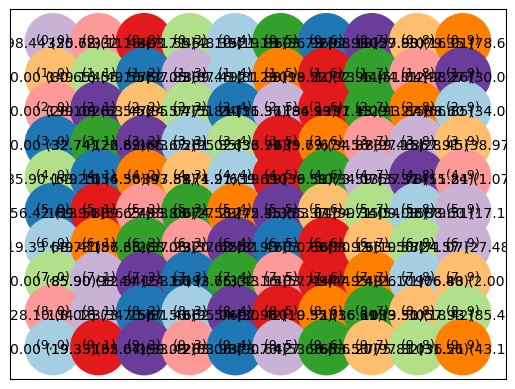

In [11]:
draw_disjunctive_graph(automaton)

### Backtrack dispatching order

We backtrack a dispatch order that leads to the given optimal schedule. Note that there may be multiple valid such dispatching orders.

In [12]:
from random import choice

def collect_state_action_pairs(instance, schedule):
    """Collect states and actions leading to the given schedule.
    `schedule` is a dict mapping each operation (i, j) to its starting times.
    """
    automaton = Automaton(instance)
    # initial state is empty disjunctive graph
    states = [automaton.D.copy()]
    actions = []

    ## compute machine order from optimal schedule
    # for each machine, collect the operations that need it
    machine_order = { m: [] for m in automaton.machine_indices }
    for i, j in automaton.indices:
        machine_order[automaton.order[i][j]].append((i, j))
    # for each machine, sort these operations according to the scheduled starting time
    for m in automaton.machine_indices:
        # reversed(...) to use same convention as automaton.unscheduled
        machine_order[m] = list(reversed(sorted(machine_order[m], key=lambda ij: schedule[ij])))

    ## replay on the automaton to collect disjunctive graph states
    while not automaton.done:
        # valid operation must be next w.r.t. to job and w.r.t. to machine order
        next_per_job = set((i, automaton.unscheduled[i][-1]) for i in automaton.unscheduled)
        next_per_machine = set(machine_order[m][-1] for m in machine_order)
        valid_operations = list(next_per_job & next_per_machine)
        
        # randomly choose a valid operation to dispatch next
        i, j = choice(valid_operations)
        automaton.step(i) # (automaton can deduce j)

        # record state-action pair
        actions.append((i, j))
        states.append(automaton.D.copy())

        # update our precomputed machine_order
        m = automaton.order[i][j]
        machine_order[m].pop()
        if len(machine_order[m]) == 0:
            del machine_order[m]

    return states, actions

Verify correctness by replaying the actions.

In [13]:
from networkx import get_node_attributes
import math

instance = generate_instance(machines=4, jobs=3)
schedule, obj = solve(instance)

states, actions = collect_state_action_pairs(instance, schedule)
automaton = Automaton(instance)
for a in actions:
    i, j = a
    automaton.step(i)
LB = get_node_attributes(automaton.D, 'LB')
makespan = max(LB[i, j] + automaton.processing[i][j] for i, j in automaton.indices)
assert math.isclose(makespan, obj)

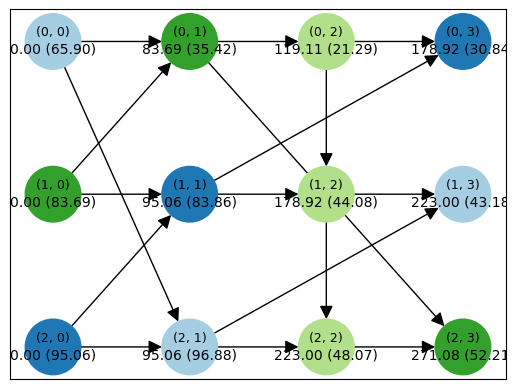

In [14]:
draw_disjunctive_graph(automaton)

### Generate training data

We solve a couple of instances and collect all the state-action pairs in a single dataset to support mini-batching via the `DataLoader` class.

In [15]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx

# force double during conversion
torch.set_default_dtype(torch.float64)

# number of valid actions is total number of operations
instance = generate_instance()
automaton = Automaton(instance)
valid_actions = list(automaton.D.nodes)

def generate_data(N):
    """Generate a set of graphs based on solving N problem instances to optimality."""
    graphs = []
    for _ in trange(N):
        instance = generate_instance()
        y, obj = solve(instance)
    
        states, actions = collect_state_action_pairs(instance, y)
        for state, action in zip(states, actions):        
            graph = from_networkx(state, group_node_attrs=['LB'])
            graph.action = valid_actions.index(action) # map to integers indices
            graphs.append(graph)
    return graphs

In [16]:
data = DataLoader(generate_data(4), batch_size=2, shuffle=True)
next(iter(data))

  0%|          | 0/4 [00:00<?, ?it/s]

DataBatch(edge_index=[2, 270], label=[200, 2], done=[200], action_mask=[200], weight=[270], arc_type=[2], x=[200, 1], action=[2], batch=[200], ptr=[3])

### Imitation learning with GNN policy

In [17]:
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch_geometric.nn import GINConv

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # we need a separate layer for the first iteration, because the initial
        # feature dimension in different from the node embedding dimension
        lin0 = Sequential(Linear(1, 16), ReLU(), Linear(16, 32), ReLU(), BatchNorm1d(32))
        self.gin0 = GINConv(lin0, train_eps=True)

        lin1 = Sequential(Linear(32, 32), ReLU(), Linear(32, 32), ReLU(), BatchNorm1d(32))
        self.gin1 = GINConv(lin1, train_eps=True)
        
        self.lin1 = Linear(32, 32)
        self.lin2 = Linear(32, 16)
        self.lin3 = Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gin0(x, edge_index)
        x = self.gin1(x, edge_index)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)

        return x.squeeze()

model = GNN()

In [18]:
from torch_geometric.utils import softmax
import torch.nn.functional as F
import torch.optim as optim

def stacked_batch(batch, indices):
    """Transform a 'flat batch' of dimension (N*B), where N is number of graphs
    in batch and B is number of nodes per graph, to a 'stacked batch' of
    dimension (N, B), based on batch indices `batch.batch`."""
    unique = torch.unique(indices)
    return torch.vstack([batch[indices == i] for i in unique])

N = 500 # number of instances for training
data_train = DataLoader(generate_data(N), batch_size=10, shuffle=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5
print("\ntraining model\n")
model.train()
for i in range(epochs):
    loss_total = 0
    print(f'epoch: {i}')
    for batch in data_train:
        optimizer.zero_grad()
        # compute node (operation) scores
        y = model(batch)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf) # ignore invalid
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        target = batch.action
        loss = F.cross_entropy(pred, target)
        loss.backward()
        loss_total += loss
        optimizer.step()
    print(f"loss: {loss_total.item()}")


training model

epoch: 0
loss: 10621.600246915052
epoch: 1
loss: 10598.206016086824
epoch: 2
loss: 10592.198970218782
epoch: 3
loss: 10589.951874262359
epoch: 4
loss: 10584.584688494782


### Evaluate imitation

In [20]:
from torch import argmax

def evaluate_imitation(model, N=100):
    """Measure accuracy based on unseen expert demonstration state-action pairs."""
    model.eval()
    print("\ngenerating test data\n")
    data_test = DataLoader(generate_data(N))
    total_correct = 0
    print("\nevaluating imitation accuracy\n")
    for batch in tqdm(data_test):
        # compute node scores
        y = model(batch)
        # mask invalid actions (set to -inf)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf)
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        pred = argmax(pred, dim=1)
        target = batch.action
        total_correct += pred == target
    print(f"accuracy: {total_correct.item() / len(data_test)}")

In [21]:
evaluate_imitation(model)


generating test data



  0%|          | 0/100 [00:00<?, ?it/s]


evaluating imitation accuracy



  0%|          | 0/10000 [00:00<?, ?it/s]

accuracy: 0.174


### Evaluate scheduling

In [22]:
from torch import masked_select

def evaluate_scheduling(model, N=100):
    """Evaluate average objective when executing the policy over full
    unseen problem instances compared to average optimal objective."""
    print("\nevaluating policy\n")
    model.eval()
    obj_opt = 0
    obj_model = 0
    for _ in trange(N):
        instance = generate_instance()

        # solve optimally
        y, obj = solve(instance)
        obj_opt += obj

        # TEST objective definition
        # _, actions, _ = collect_state_action_pairs(instance, y)

        # execute learned heuristic
        automaton = Automaton(instance)
        while not automaton.done:
            state = automaton.D
            graph = from_networkx(state, group_node_attrs=['LB'])
            # compute node scores
            y = model(graph)
            # mask invalid actions (set to -inf)
            y = y.masked_fill(~graph.action_mask.bool(), -torch.inf)
            y = argmax(y)
            # translate index back to actual action
            action = valid_actions[y]
            i, j = action
            # execute action on automaton
            automaton.step(i)

        # TEST objective definition
        # for action in actions:
        #     r, k, v = action
        #     automaton.step(r, v)

        # compute obj from automaton
        obj_model += automaton.get_obj()

    print(f"obj_opt={obj_opt / N} vs obj_model={obj_model / N}")
    print(f"approximation ratio={obj_model / obj_opt}")

In [23]:
evaluate_scheduling(model)


evaluating policy



  0%|          | 0/100 [00:00<?, ?it/s]

obj_opt=827.664986815183 vs obj_model=1018.8290039793184
approximation ratio=1.2309678676872942
